# Portfolio estimation

Small functions to visualize stock market data and calculate basic portfolio numbers

In [1]:
from pandas_datareader.data import DataReader
from pandas_datareader.moex import MoexReader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
start_date = "01-01-2014"
end_date = "06-01-2018"
tickers = ["AAPL", "MSFT", "NFLX"]
#platform = 'iex' 
platform = 'yahoo'
data = DataReader(tickers, platform, start_date, end_date)
try:
    #Yahoo
    tickers_data = data["Close"]
except:
    #iex
    tickers_data = data["close"]

In [3]:
def corrfunc(x, y, **kws):
    r, _ = scipy.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

def plot_adjusted_price(ticker_price):
    ticker_price = ticker_price / ticker_price.iloc[0, :]
    ax = ticker_price.plot(figsize=(16,9))
    ax.set_ylabel('Adjusted closing price ($)')
    
def plot_instruments_correlation(ticker_price):
    g = sns.PairGrid(ticker_price, height=4.5)
    g.map_upper(plt.scatter, s=1, marker=".", alpha=0.25)
    g.map_diag(sns.distplot, kde=False)
    g.map_lower(sns.kdeplot, cmap="Blues_d")
    g.map_lower(corrfunc)
    
def plot_mean_avg(ticker_price, windows=(20, 100)):
    fig, ax = plt.subplots(figsize=(16,9))
    ax.plot(ticker_price.index, ticker_price, label=ticker_price.name)
    for w in windows:
        rolling_ticker_price = ticker_price.rolling(window=w).mean()
        ax.plot(rolling_ticker_price.index, rolling_ticker_price, label='%d days rolling' % w)
        ax.set_xlabel('Date')
        ax.set_ylabel('Adjusted closing price ($)')
        ax.legend()
        
def plot_accumulated_log_return(ticker_price):
    ticker_price = ticker_price / ticker_price.iloc[0, :]
    ticker_price = np.log(ticker_price)
    ax = ticker_price.plot(figsize=(16,9))
    ax.set_ylabel('Accumulated log return')
    
def correlation_matrix(tickers_price):
    corr = tickers_price.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(13, 13))
    ax = sns.heatmap(corr, mask=mask, square=True, annot=corr, vmin=-1, vmax=1, cmap='RdBu_r', cbar=False)

In [4]:
log_returns = np.log(tickers_data) - np.log(tickers_data.iloc[0, :])
portfolio_weights = pd.Series(1 / 3, index=tickers_data.columns)

Text(0,0.5,'Portfolio cumulative log returns')

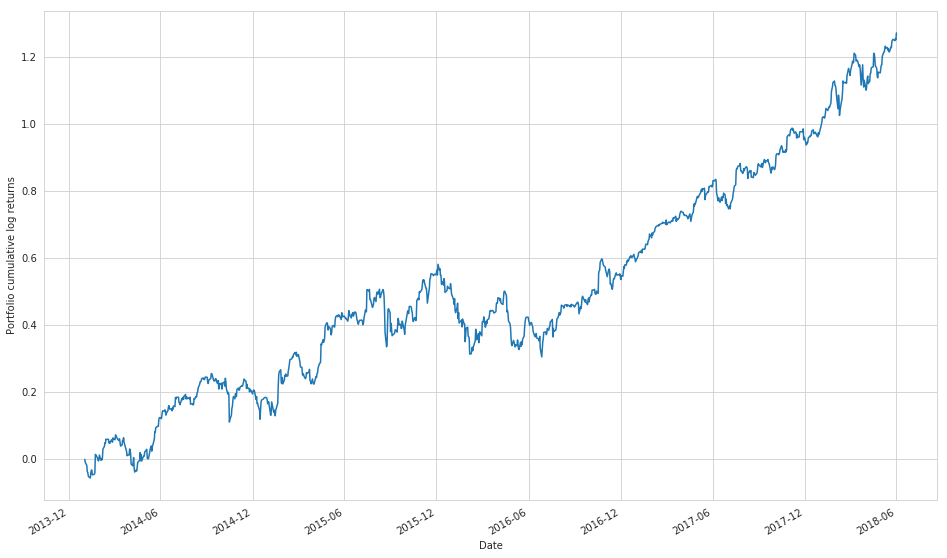

In [5]:
portfolio_log_returns = portfolio_weights.dot(log_returns.transpose())
ax = portfolio_log_returns.plot(figsize=(16,10))
ax.set_ylabel('Portfolio cumulative log returns')

In [7]:
# Calculating the time-related parameters of the simulation
total_days_in_simulation = (tickers_data.index[-1] - tickers_data.index[0]).days
number_of_years = total_days_in_simulation / 365.25

# The last data point will give us the total portfolio return
total_portfolio_return = np.exp(portfolio_log_returns[-1])
# Average portfolio return assuming compunding of returns
average_yearly_return = (1 + total_portfolio_return)**(1 / number_of_years) - 1

print('Total portfolio return is: ' +
      '{:5.2f}'.format(100 * total_portfolio_return) + '%')
print('Average yearly return is: ' +
      '{:5.2f}'.format(100 * average_yearly_return) + '%')

Total portfolio return is: 356.60%
Average yearly return is: 41.10%


# Portfolio Return analysis

In [3]:
dates = [
    ("2017-11-01", "2018-11-01"),
    ("2017-05-01", "2018-05-01"),
    ("2016-11-01", "2017-11-01"),
    ("2016-05-01", "2017-05-01"),
    ("2015-11-01", "2016-11-01"),
    ("2015-05-01", "2016-05-01"),
]
start_dates, end_dates = zip(*dates)
start_dates = list(map(pd.Timestamp, start_dates))
end_dates = list(map(pd.Timestamp, end_dates))

#portfolio_weights["portfolio2"] = 0
shares = {
"FXGD": 0.1,
"FXMM": 0.025,
"FXJP": 0.075,
"FXRB": 0.15,
"FXRU": 0.15,
"FXIT": 0.025,
"MOEX": 0.025,
"PLZL": 0.035,
"MTSS": 0.035,
"LSNGP": 0.025,
"yndx": 0.04,
"AFLT": 0.04,
"PIKK": 0.04,
"V": 0.025,
"NVDA": 0.025,
"INTC": 0.025,
"AAPL":0.025,
"FB": 0.01,
"NFLX": 0.02,
"USD000UTSTOM": 0,
"EUR_RUB__TOM": 0.105,
}
print(sum(shares.values()))


symbols = list(shares.keys())

1.0


In [ ]:
pd.Series()

In [6]:
#symbols = ["USD000UTSTOM", "EUR_RUB__TOM", "yndx"]

def getMoexData(symbol, start_date, end_date):
    t = MoexReader(symbol, start_date, end_date).read()
    t = t[~t.CLOSE.isna()]
    boardid = t.BOARDID.groupby(t.BOARDID).count().idxmax()
    t = t[t.BOARDID == boardid]
    #t = t.groupby(t.index).aggregate({"CLOSE": "max"})
    t = t.drop_duplicates()
    t.index = pd.DatetimeIndex(t.index)
    t = t[~t.CLOSE.isna()]
    return t.CLOSE

def getOtherData(symbol, start_date, end_date):
    try:
        #Yahoo
        data = DataReader([symbol], 'yahoo', start_date, end_date)
        tickers_data = data["Close"]
    except:
        #iex
        data = DataReader([symbol], 'iex', start_date, end_date)
        tickers_data = data["close"]
    return tickers_data

def getData(symbols, start_date, end_date):
    res = pd.DataFrame(columns=symbols, index=pd.date_range(pd.Timestamp(start_date), pd.Timestamp(end_date)))
    for s in symbols:
        print(s)
        try:
            res[s] = getMoexData(s, start_date, end_date)
        except:
            res[s] = getOtherData(s, start_date, end_date)
    res[res==0] = float("nan")
    return res.fillna(method="ffill").fillna(method="bfill")

In [18]:
symbols= ["USD000UTSTOM", "USD000TODTOM"]
start_date = "2000-01-01"
end_date = "2019-03-01"
tickers_data =  getData(symbols, start_date=start_date, end_date=end_date)

USD000UTSTOM


/home/k/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: pandas.core.common.is_list_like is deprecated. import from the public API: pandas.api.types.is_list_like instead
  after removing the cwd from sys.path.


USD000TODTOM


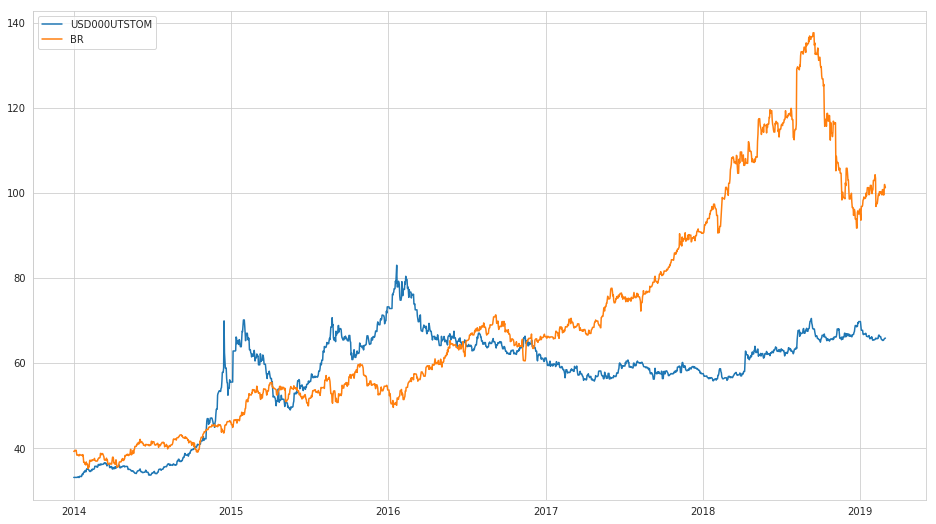

In [14]:
tickers_data.plot(figsize=(16,9))

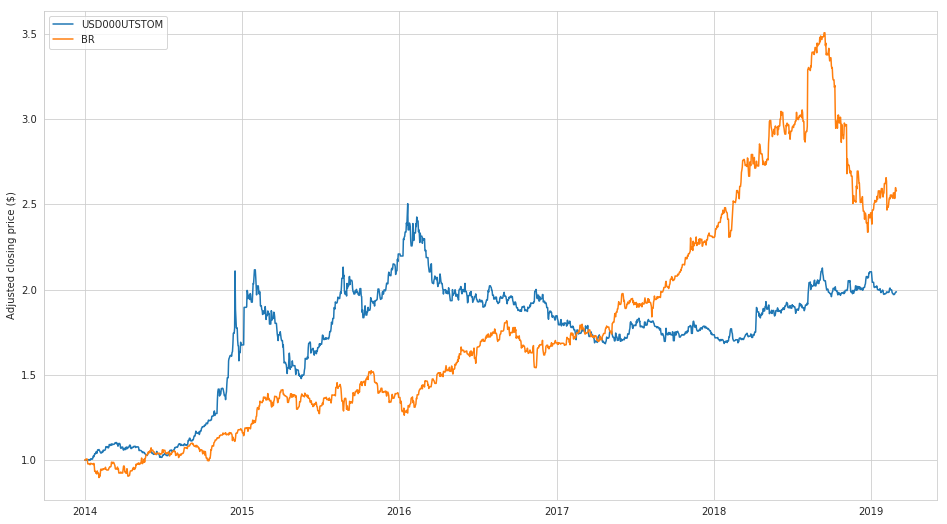

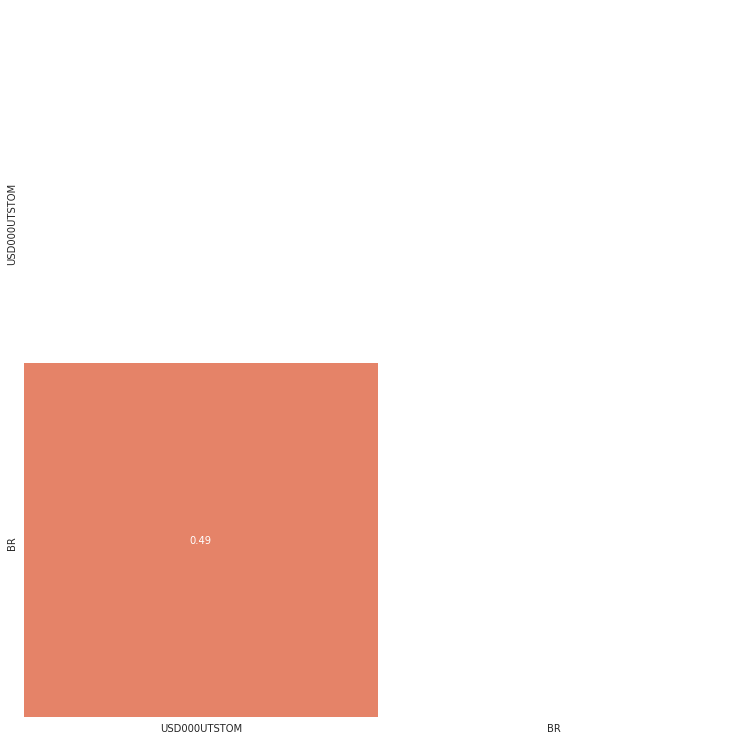

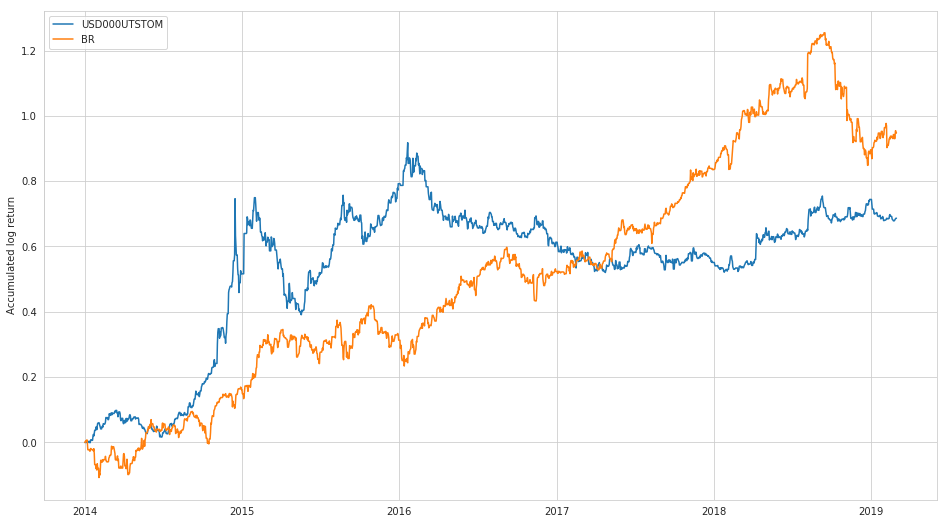

In [11]:
plot_adjusted_price(tickers_data)
correlation_matrix(tickers_data)
plot_accumulated_log_return(tickers_data)

In [12]:
plot_accumulated_log_return(tickers_data[["yndx", "FXRB", "FXRU", "EUR_RUB__TOM", "USD000UTSTOM"]])
plot_adjusted_price(tickers_data[["yndx", "FXRB", "FXRU", "EUR_RUB__TOM", "USD000UTSTOM"]])

KeyError: "['yndx' 'FXRB' 'FXRU' 'EUR_RUB__TOM'] not in index"

In [81]:
returns = tickers_data.loc[end_dates, :].reset_index(drop=True) / tickers_data.loc[start_dates, :].reset_index(drop=True)
returns.index = end_dates
returns

,MTSS,NVDA,V,EUR_RUB__TOM,FXRU,NFLX,AAPL,yndx,FXIT,MOEX,...,LSNGP,FXGD,FB,INTC,FXJP,PLZL,PIKK,AFLT,USD000UTSTOM,FXMM
2018-11-01,0.897480,1.052654,1.267939,1.110474,1.129283,1.602929,1.331536,1.003766,1.271702,0.748627,...,1.134364,1.080229,0.830778,1.032327,1.056139,0.861400,1.137665,0.587508,1.128670,1.055352
2018-05-01,1.082344,2.129970,1.397217,1.213440,1.121113,2.016736,1.153636,1.366895,1.373048,1.049544,...,2.174710,1.133789,1.140365,1.468741,1.309904,0.906924,1.062804,0.819346,1.107606,1.069345
2017-11-01,1.286321,3.000724,1.360818,0.971942,0.974203,1.605839,1.496906,1.601528,1.259049,1.031822,...,1.746625,0.904145,1.410502,1.353129,1.090050,1.096789,1.078765,1.230230,0.922626,1.082853
2017-05-01,1.082411,3.001407,1.181512,0.846197,0.934251,1.725536,1.563687,1.179477,1.179343,1.126285,...,3.535836,0.854758,1.296649,1.199141,1.008593,0.923867,1.151418,2.268327,0.886254,1.084009
2016-11-01,1.073932,2.433909,1.052075,0.983305,1.073290,1.137664,0.932971,1.223917,1.065406,1.276714,...,3.979339,1.100760,1.269981,1.019492,1.006006,1.559858,1.295281,2.735510,0.985953,1.092566
2016-05-01,0.954717,1.561758,1.174396,1.285885,1.400428,1.131375,0.726948,1.299700,1.192932,1.326623,...,1.344037,1.378596,1.488543,0.906044,1.110979,3.086084,1.303646,2.030931,1.245369,1.110991


In [82]:
returns.describe()

,MTSS,NVDA,V,EUR_RUB__TOM,FXRU,NFLX,AAPL,yndx,FXIT,MOEX,...,LSNGP,FXGD,FB,INTC,FXJP,PLZL,PIKK,AFLT,USD000UTSTOM,FXMM
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,1.062868,2.196737,1.238993,1.068540,1.105428,1.536680,1.200947,1.279214,1.223580,1.093269,...,2.319152,1.075380,1.239470,1.163146,1.096945,1.405820,1.171596,1.611975,1.046079,1.082519
std,0.134063,0.783163,0.128941,0.164940,0.164557,0.346057,0.327093,0.200435,0.103759,0.206718,...,1.178114,0.186556,0.233384,0.216624,0.112550,0.862564,0.104639,0.859323,0.137639,0.019108
min,0.897480,1.052654,1.052075,0.846197,0.934251,1.131375,0.726948,1.003766,1.065406,0.748627,...,1.134364,0.854758,0.830778,0.906044,1.006006,0.861400,1.062804,0.587508,0.886254,1.055352
25%,0.984521,1.703811,1.176175,0.974783,0.998975,1.253980,0.988137,1.190587,1.182741,1.036253,...,1.444684,0.948166,1.172769,1.022701,1.020479,0.911160,1.093490,0.922067,0.938458,1.072722
50%,1.078138,2.281940,1.224726,1.046889,1.097201,1.604384,1.242586,1.261809,1.225991,1.087914,...,1.960668,1.090495,1.283315,1.115734,1.073094,1.010328,1.144542,1.630580,1.046779,1.083431
75%,1.082394,2.859020,1.337599,1.187698,1.127241,1.695612,1.455563,1.350096,1.268539,1.239107,...,3.195555,1.125532,1.382039,1.314632,1.105746,1.444091,1.259315,2.208978,1.123404,1.090427
max,1.286321,3.001407,1.397217,1.285885,1.400428,2.016736,1.563687,1.601528,1.373048,1.326623,...,3.979339,1.378596,1.488543,1.468741,1.309904,3.086084,1.303646,2.735510,1.245369,1.110991


In [83]:
returns.std().sort_values().index

Index(['FXMM', 'FXRB', 'FXIT', 'PIKK', 'FXJP', 'V', 'MTSS', 'USD000UTSTOM',
       'FXRU', 'EUR_RUB__TOM', 'FXGD', 'yndx', 'MOEX', 'INTC', 'FB', 'AAPL',
       'NFLX', 'NVDA', 'AFLT', 'PLZL', 'LSNGP'],
      dtype='object')

In [84]:
returns.describe()[returns.std().sort_values().index]

,FXMM,FXRB,FXIT,PIKK,FXJP,V,MTSS,USD000UTSTOM,FXRU,EUR_RUB__TOM,...,yndx,MOEX,INTC,FB,AAPL,NFLX,NVDA,AFLT,PLZL,LSNGP
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,1.082519,1.132626,1.223580,1.171596,1.096945,1.238993,1.062868,1.046079,1.105428,1.068540,...,1.279214,1.093269,1.163146,1.239470,1.200947,1.536680,2.196737,1.611975,1.405820,2.319152
std,0.019108,0.075856,0.103759,0.104639,0.112550,0.128941,0.134063,0.137639,0.164557,0.164940,...,0.200435,0.206718,0.216624,0.233384,0.327093,0.346057,0.783163,0.859323,0.862564,1.178114
min,1.055352,1.025550,1.065406,1.062804,1.006006,1.052075,0.897480,0.886254,0.934251,0.846197,...,1.003766,0.748627,0.906044,0.830778,0.726948,1.131375,1.052654,0.587508,0.861400,1.134364
25%,1.072722,1.088349,1.182741,1.093490,1.020479,1.176175,0.984521,0.938458,0.998975,0.974783,...,1.190587,1.036253,1.022701,1.172769,0.988137,1.253980,1.703811,0.922067,0.911160,1.444684
50%,1.083431,1.141936,1.225991,1.144542,1.073094,1.224726,1.078138,1.046779,1.097201,1.046889,...,1.261809,1.087914,1.115734,1.283315,1.242586,1.604384,2.281940,1.630580,1.010328,1.960668
75%,1.090427,1.167113,1.268539,1.259315,1.105746,1.337599,1.082394,1.123404,1.127241,1.187698,...,1.350096,1.239107,1.314632,1.382039,1.455563,1.695612,2.859020,2.208978,1.444091,3.195555
max,1.110991,1.240343,1.373048,1.303646,1.309904,1.397217,1.286321,1.245369,1.400428,1.285885,...,1.601528,1.326623,1.468741,1.488543,1.563687,2.016736,3.001407,2.735510,3.086084,3.979339


In [86]:
portfolio_weights = pd.DataFrame(index=tickers_data.columns)
portfolio_weights["portfolio1"] = 1 / len(tickers_data.columns)
portfolio_weights["portfolio2"] = pd.Series(shares)

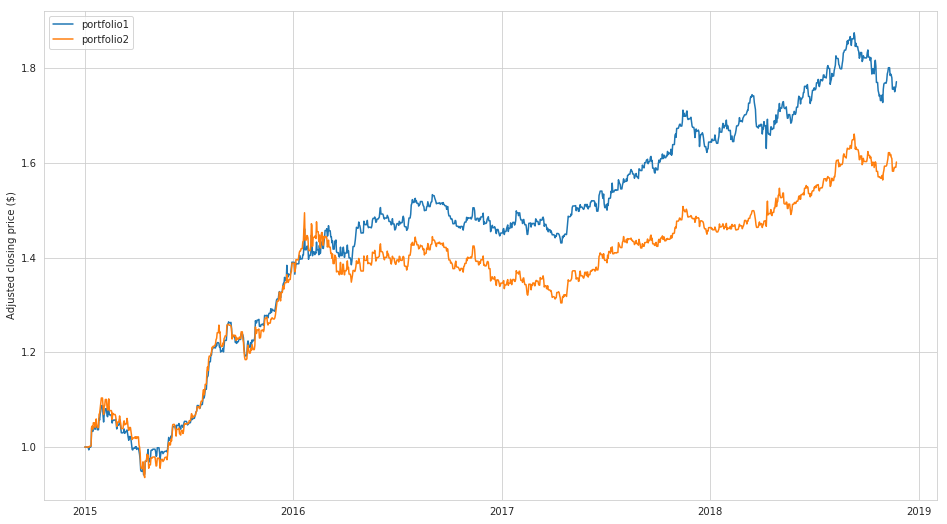

In [87]:
portfolios = tickers_data.dot(portfolio_weights)
plot_adjusted_price(portfolios)

In [91]:
# Calculating the time-related parameters of the simulation
total_days_in_simulation = (tickers_data.index[-1] - tickers_data.index[0]).days
number_of_years = total_days_in_simulation / 365.25

# The last data point will give us the total portfolio return
total_portfolio_return = portfolios.iloc[-1] / portfolios.iloc[0]
# Average portfolio return assuming compunding of returns
average_yearly_return = (1 + total_portfolio_return)**(1 / number_of_years) - 1

print('Total portfolio return is: ' +
      '{:5.2f}'.format(100 * total_portfolio_return) + '%')
print('Average yearly return is: ' +
      '{:5.2f}'.format(100 * average_yearly_return) + '%')

TypeError: non-empty format string passed to object.__format__

In [92]:
average_yearly_return

portfolio1    0.299269
portfolio2    0.278375
dtype: float64